### Setup
## Imports

In [1]:
from itertools import chain
import ujson as json
import multiprocessing as mp
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_fscore_support

from helpers import disaggregated_df
from helpers import aggregated_df
from helpers import dummify_df

%matplotlib inline
sns.set(font='monospace')
df = pd.read_pickle('../../data/merged/data_to_use.pkl')

In [2]:
print(df.columns)

Index(['class', 'phone', 'dd_id', 'price', 'duration_in_mins', 'flag', 'age',
       'area', 'area_type', 'ethnicity', 'price_per_min', 'Disease', 'Year',
       'Cases', 'Rate', 'MSA', 'property', 'rape', 'violent', 'male_wage_mean',
       'male_wage_p05', 'male_wage_p10', 'male_wage_p25', 'male_wage_p50',
       'male_wage_p75', 'male_wage_p90', 'male_wage_p95', 'male_N',
       'male_epop', 'qcew_code', 'msa', 'population', 'unemployment',
       'lt_highschool', 'highschool', 'some_college', 'college_plus',
       'frac_white', 'avg_commute', 'female_wage_mean', 'wage_var.wage',
       'female_wage_p05', 'female_wage_p10', 'female_wage_p25',
       'female_wage_p50', 'female_wage_p75', 'female_wage_p90',
       'female_wage_p95', 'female_N', 'wage_sum.wght', 'female_epop',
       'swnauthemp', 'swnftemp', 'ad_p10_msa', 'ad_p90_msa', 'ad_mean_msa',
       'ad_median_msa', 'ad_count_msa', 'ad_p50_msa'],
      dtype='object')


In [3]:
df['class'] = df['class'].apply(lambda x: 1 if x == 'positive' else 0)
df['lt_23'] = df.age.apply(lambda x: 1 if x < 23 else 0)

In [4]:
agg_category_cols = ['flag', 'ethnicity']
for a_c_c in agg_category_cols:
    df = dummify_df(df, a_c_c, '|')
    print('post-{}: {}'.format(a_c_c, df.shape))

post-flag: (63632, 70)
post-ethnicity: (63632, 91)


### Plotting indicators
Visual exploration of TGG & other indicators in the data. These graphs are done on ads. If you want to run 'em on phones, you should disambiguate differently.

#### Flags

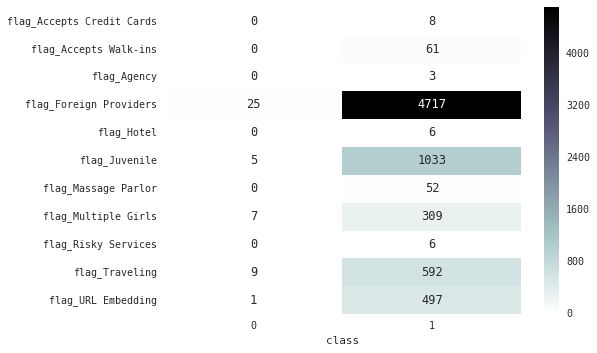

In [5]:
cols = [x for x in df.columns if x.split('_')[0] == 'flag']
a = df.ix[:, ['dd_id', 'class']+cols].drop_duplicates().ix[:, ['class']+cols]
ct = a.groupby('class').sum()
sns.heatmap(ct.T, annot=True, fmt='d', cmap='bone_r')

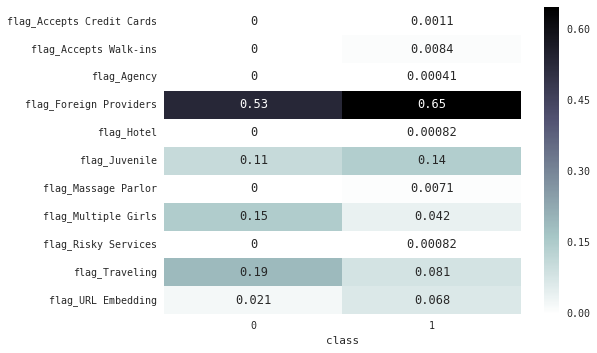

In [6]:
sns.heatmap(ct.T/ct.sum(axis=1), annot=True, cmap='bone_r')

#### Ethnicity

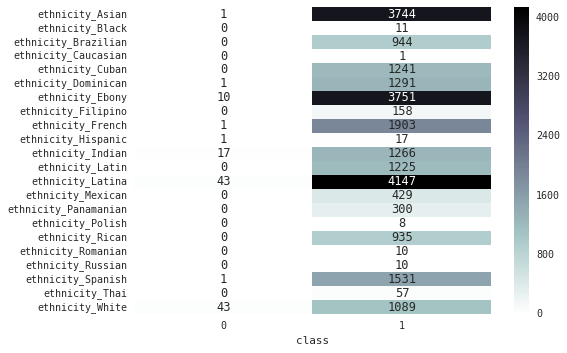

In [7]:
cols = [x for x in df.columns if x.split('_')[0] == 'ethnicity']
a = df.ix[:, ['dd_id', 'class']+cols].drop_duplicates().ix[:, ['class']+cols]
ct = a.groupby('class').sum()
sns.heatmap(ct.T, annot=True, fmt='d', cmap='bone_r')

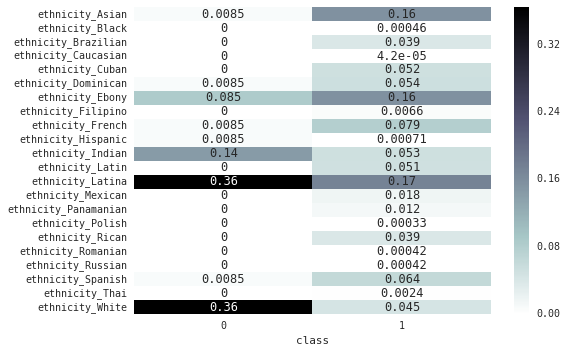

In [8]:
sns.heatmap(ct.T/ct.sum(axis=1), annot=True, cmap='bone_r')

#### Price

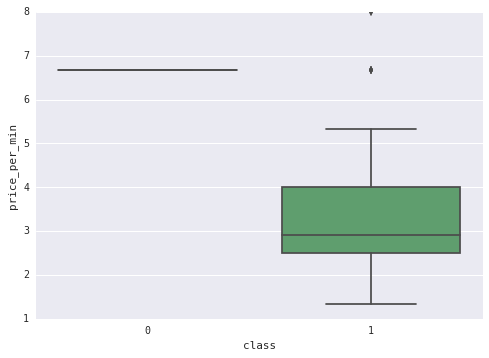

In [9]:
a = df.ix[:, ['dd_id', 'class', 'price_per_min']].dropna().drop_duplicates().ix[:, ['class', 'price_per_min']]
sns.boxplot(a['class'], a['price_per_min'])

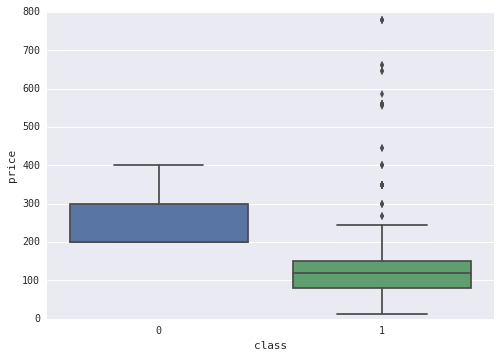

In [10]:
a = df.ix[:, ['dd_id', 'class', 'price']].dropna().drop_duplicates().ix[:, ['class', 'price']]
sns.boxplot(a['class'], a['price'])

#### Age

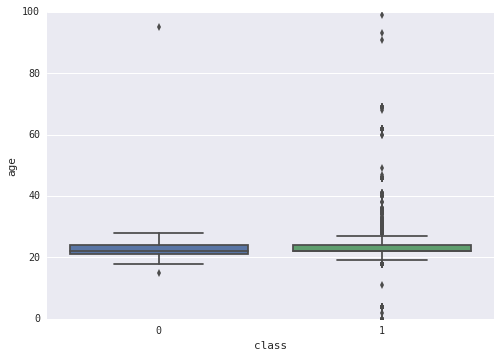

In [11]:
a = df.ix[:, ['dd_id', 'class', 'age']].dropna().drop_duplicates().ix[:, ['class', 'age']]
sns.boxplot(a['class'], a['age'])

# Classifiers
## Linreg

We're using simple folds. These should perhaps be improved to deal with demographic bias.

### Slice DF

In [12]:
flag_cols = [x for x in df.columns if x.split('_')[0] == 'flag']
eth_cols = [x for x in df.columns if x.split('_')[0] == 'ethnicity']

cols_to_use = ['age',
               'lt_23',
               'price',
               'duration_in_mins',
               'price_per_min'] + flag_cols + eth_cols

df_slice = df.ix[:, ['class',
                     'phone',
                     'dd_id'] + cols_to_use].copy().drop_duplicates()

print(df_slice.shape)

# Fill NAs
df_slice.age = df_slice.age.fillna(5000000)
df_slice.price = df_slice.price.fillna(5000000)
df_slice.duration_in_mins = df_slice.duration_in_mins.fillna(5000000)
df_slice.price_per_min = df_slice.price_per_min.fillna(5000000)


# Dropped duplicates should kill identical ads
# WE NEED TO GROUP ON PHONES
# But I'm not going to think about that right now, so ads it is
df_X = df_slice.ix[:, cols_to_use]
y_series = df_slice['class'].astype(int)
print(df_X.shape)
print(y_series.shape)

(18314, 41)
(18314, 38)
(18314,)


### Get Train / Test splits, folds, or whatever you want to call them
Splitting *after* dropping a bunch of duplicates. We want the phone number to be the primary key.

In [13]:
splitter = ShuffleSplit(df_X.shape[0], 10)
splits = [x for x in splitter]

In [14]:
df_X['lt_23'] = df_X.lt_23.astype(int)

### Run model

In [15]:
def train_tester(df_X_train, y_train, df_X_test, y_test):
    lr = LinearRegression()
    lr.fit(df_X_train, y_train)
    y_pred = lr.predict(df_X_test)
    fpr, tpr, thresholds = roc_curve(y_test.values, y_pred)
    # precision, recall, f_score, support = precision_recall_fscore_support(y_test.values, y_pred)
    return {'model':lr,
            'y_pred': y_pred,
            'y_test': y_test.values,
            'lr_score': lr.score(df_X_test, y_test),
            'roc': {'fpr': fpr,
                    'tpr': tpr,
                    'thresholds': thresholds,
                    'auc': auc(fpr, tpr)},
            # 'precision_recall': {'p': precision,
            #                     'r': recall,
            #                     'f1': f_score,
            #                     'support': support}
            }


p = mp.Pool(10)
lrs = p.starmap(train_tester,
                [(df_X.iloc[train_ix, :],
                  y_series.iloc[train_ix],
                  df_X.iloc[test_ix, :],
                  y_series.iloc[test_ix])
                 for train_ix, test_ix in splits])
p.close()
p.join()

In [16]:
pd.Series([lr['roc']['auc'] for lr in lrs]).describe()

count    10.000000
mean      0.861878
std       0.010961
min       0.834293
25%       0.860330
50%       0.864377
75%       0.865621
max       0.877466
dtype: float64

With these splits and features, our linear model _juuuuust_ a little better than the mean. Thanks, skewed data :(

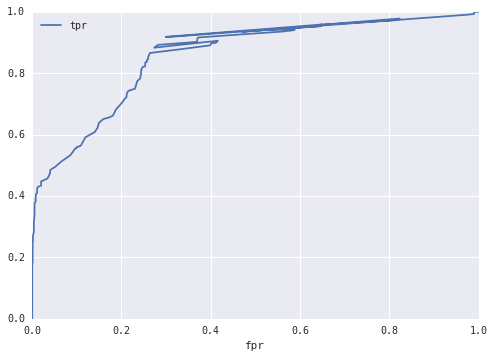

In [24]:
roc_df = pd.DataFrame({'fpr': pd.DataFrame.from_records([lr['roc']['fpr'] for lr in lrs]).apply(np.mean),
                       'tpr': pd.DataFrame.from_records([lr['roc']['tpr'] for lr in lrs]).apply(np.mean)})
roc_df.set_index('fpr', inplace=True)
roc_df.plot()